# SpaceX Falcon 9 Data Collection and Enrichment


## 1. Introduction  

This notebook demonstrates data collection and enrichment for **SpaceX Falcon 9 launches**. It shows:  

- 📡 API-based data collection from the SpaceX API  
- 🌦️ Weather data integration using Meteostat  
- 🌐 Web scraping demo from Wikipedia (for portfolio purposes)  

> **Note:** Exploratory data analysis (EDA) will be performed in a separate notebook.  


## 2. Libraries and Set up
Import all necessary Python libraries for data manipulation, API requests, date handling, and visualization. Also configure display settings for cleaner output.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# API requests
import requests

# Date/time handling
import datetime

# Visualization (for web scraping demo)
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 3. Helper Functions
Define reusable functions for extracting and processing data from APIs and HTML tables. These functions streamline data collection and cleaning tasks.

### 3.1 API Helper Functions
Functions to fetch detailed launch, rocket, payload, and core information from the SpaceX API using ID references.


In [ ]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])


### 3.2 Web Scraping Helper Functions

Functions to parse and clean HTML tables from Wikipedia, including extracting dates, booster versions, landing status, and payload masses.

In [ ]:
from bs4 import BeautifulSoup
import unicodedata

def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate(table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else:
        new_mass = 0
    return new_mass

def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

def get_cell_text(cell):
    if cell is None:
        return None
    if cell.a and cell.a.string:
        return cell.a.string.strip()
    return cell.get_text(strip=True) if cell.get_text() else None


## 4. Collect API Launch Data
Fetch historical SpaceX launch data from the API and filter for single-core, single-payload launches. Convert dates and prepare the dataset for enrichment.

In [ ]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
data = pd.json_normalize(response.json())

# Select relevant columns and filter for single-core, single-payload launches
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

Below we display the first 5 rows of the raw SpaceX API launch data to inspect the initial structure and available columns.


In [ ]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


## 5. API Data Extraction
Use the helper functions to retrieve booster, payload, launch site, and core information. Store results in lists and consolidate into a structured DataFrame.


In [ ]:
# Global lists for API data
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

# Call API functions
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

# Construct DataFrame
launch_dict = {
    'FlightNumber': list(data['flight_number']),
    'Date': list(data['date']),
    'BoosterVersion': BoosterVersion,
    'PayloadMass': PayloadMass,
    'Orbit': Orbit,
    'LaunchSite': LaunchSite,
    'Outcome': Outcome,
    'Flights': Flights,
    'GridFins': GridFins,
    'Reused': Reused,
    'Legs': Legs,
    'LandingPad': LandingPad,
    'Block': Block,
    'ReusedCount': ReusedCount,
    'Serial': Serial,
    'Longitude': Longitude,
    'Latitude': Latitude
}

data = pd.DataFrame(launch_dict)

# Keep only Falcon 9 launches
data_falcon9 = data[data['BoosterVersion'] != 'Falcon 1'].copy()
data_falcon9['FlightNumber'] = range(1, len(data_falcon9) + 1)

After extracting relevant information from the API (rocket, payload, cores, and launchpad), we show the first 5 rows of the Falcon 9 launch dataset.


In [ ]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## 6. Handle Missing Values
Identify missing values in the dataset and handle them appropriately, such as imputing payload mass with the mean.

In [ ]:
# Fill missing PayloadMass with mean
avg_payload = data_falcon9['PayloadMass'].astype(float).mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(avg_payload)

## 7. Weather Data Integration
Enrich the Falcon 9 launch dataset with historical weather data (temperature, wind speed) for each launch location using the Meteostat API. Handle missing weather values with launch-site-specific means.

In [ ]:
# Install Meteostat if needed
%pip install meteostat

from meteostat import Point, Daily
import pandas as pd

# Make a copy of your Falcon 9 data
df_falcon9_with_weather = data_falcon9.copy()

# Initialize list to collect weather data
weather_data = []

for idx, row in df_falcon9_with_weather.iterrows():
    location = Point(row['Latitude'], row['Longitude'])
    launch_date = pd.to_datetime(row['Date'])

    # Fetch daily weather for the launch day
    daily = Daily(location, launch_date, launch_date).fetch()

    if not daily.empty:
        weather_data.append({
            'FlightNumber': row['FlightNumber'],
            'TemperatureAvg': daily['tavg'].values[0],
            'Precipitation': daily['prcp'].values[0],
            'WindSpeed': daily['wspd'].values[0]
        })
    else:
        weather_data.append({
            'FlightNumber': row['FlightNumber'],
            'TemperatureAvg': None,
            'Precipitation': None,
            'WindSpeed': None
        })

# Create weather DataFrame
df_weather = pd.DataFrame(weather_data)

# Merge weather data
df_falcon9_with_weather = df_falcon9_with_weather.merge(df_weather, on='FlightNumber', how='left')

# Drop Precipitation due to many missing values
df_falcon9_with_weather.drop('Precipitation', axis=1, inplace=True)

# Convert weather columns to numeric to prevent FutureWarnings
df_falcon9_with_weather['TemperatureAvg'] = pd.to_numeric(df_falcon9_with_weather['TemperatureAvg'], errors='coerce')
df_falcon9_with_weather['WindSpeed'] = pd.to_numeric(df_falcon9_with_weather['WindSpeed'], errors='coerce')

# Fill missing values by LaunchSite group
df_falcon9_with_weather['TemperatureAvg'] = (
    df_falcon9_with_weather.groupby('LaunchSite')['TemperatureAvg']
    .transform(lambda x: x.fillna(x.mean()))
)

df_falcon9_with_weather['WindSpeed'] = (
    df_falcon9_with_weather.groupby('LaunchSite')['WindSpeed']
    .transform(lambda x: x.fillna(x.mean()))
)

# Export to CSV
df_falcon9_with_weather.to_csv('dataset_part_1.csv', index=False)

We merge weather information from Meteostat with the Falcon 9 dataset. The first 5 rows of the enriched dataset show average temperature, wind speed, and other key launch information.


In [ ]:
df_falcon9_with_weather.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,TemperatureAvg,WindSpeed
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,25.7,9.7
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,24.7,13.5
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,14.8,15.3
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,15.1,10.8
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,18.1,5.7


### Dataset Summary

The final Falcon 9 dataset contains 90 launches (up to November 2020) with 19 features, including booster version, payload mass, orbit, launch site, landing outcome, and weather data. The dataset is now ready for exploratory data analysis in the next notebook.

## 8. Web Scraping Demo
Demonstrate web scraping skills by extracting launch data from Wikipedia tables. This section is for portfolio purposes and is not used in the main modeling dataset.

In [ ]:


static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response = requests.get(static_url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

html_tables = soup.find_all('table')
first_launch_table = html_tables[2]

# Extract column names
column_names = [extract_column_from_header(th) for th in first_launch_table.find_all('th') if extract_column_from_header(th)]
launch_dict= {key: [] for key in column_names}

# Set extra key names
del launch_dict['Date and time ( )']
launch_dict['Date'] = []
launch_dict['Time'] = []
launch_dict['Version Booster'] = []
launch_dict['Booster landing'] = []

# Extract rows
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th and rows.th.string and rows.th.string.strip().isdigit():
            flight_number = rows.th.string.strip()
            row = rows.find_all('td')
            launch_dict['Flight No.'].append(flight_number)
            datatimelist = date_time(row[0])
            launch_dict['Date'].append(datatimelist[0].strip(','))
            launch_dict['Time'].append(datatimelist[1])
            launch_dict['Version Booster'].append(booster_version(row[1]) or get_cell_text(row[1]))
            launch_dict['Launch site'].append(get_cell_text(row[2]))
            launch_dict['Payload'].append(get_cell_text(row[3]))
            launch_dict['Payload mass'].append(get_mass(row[4]))
            launch_dict['Orbit'].append(get_cell_text(row[5]))
            launch_dict['Customer'].append(get_cell_text(row[6]))
            launch_dict['Launch outcome'].append(row[7].get_text(strip=True) if row[7] else None)
            launch_dict['Booster landing'].append(landing_status(row[8]))

df_webscrape = pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

# Clean Payload Mass
df_webscrape['Payload mass'] = pd.to_numeric(df_webscrape['Payload mass'].str.replace(' kg','', regex=False), errors='coerce')
df_webscrape.rename(columns={'Payload mass': 'Payload mass (kg)'}, inplace=True)
df_webscrape['Launch Success'] = df_webscrape['Launch outcome'].apply(lambda x: 1 if 'Success' in x else 0)
df_webscrape['Year'] = pd.to_datetime(df_webscrape['Date']).dt.year

As a demonstration of web scraping skills, we extract Falcon launch information from Wikipedia. The first 5 rows of the scraped dataset are displayed below.


In [ ]:
df_webscrape.head()

,Flight No.,Launch site,Payload,Payload mass (kg),Orbit,Customer,Launch outcome,Date,Time,Version Booster,Booster landing,Launch Success,Year
0,1,CCAFS,Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success,4 June 2010,18:45,F9 v1.07B0003.18,Failure,1,2010
1,2,CCAFS,Dragon,NaN,LEO,NASA,Success[9],8 December 2010,15:43,F9 v1.07B0004.18,Failure,1,2010
2,3,CCAFS,Dragon,525.0,LEO,NASA,Success[20],22 May 2012,07:44,F9 v1.07B0005.18,No attempt\n,1,2012
3,4,CCAFS,SpaceX CRS-1,NaN,LEO,NASA,Success,8 October 2012,00:35,F9 v1.07B0006.18,No attempt,1,2012
4,5,CCAFS,SpaceX CRS-2,NaN,LEO,NASA,Success,1 March 2013,15:10,F9 v1.07B0007.18,No attempt\n,1,2013


## 9. Quick Visualizations (Web Scraping Demo)
Perform simple visualizations to summarize the web-scraped launch data, including launches per year and launch success vs. failure rates.

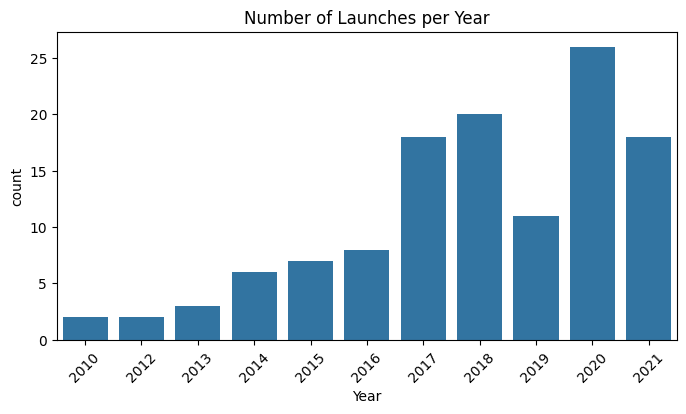

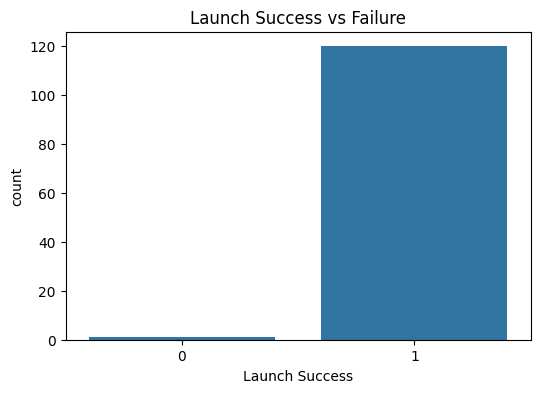

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=df_webscrape)
plt.title('Number of Launches per Year')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Launch Success', data=df_webscrape)
plt.title('Launch Success vs Failure')
plt.show()


## ✅ 10. Conclusion

This notebook demonstrates a complete **data collection and enrichment workflow** for the SpaceX Falcon 9 dataset:  

- **API integration**: Retrieved detailed launch, payload, rocket, and core data from the SpaceX REST API.  
- **Data cleaning & preparation**: Filtered launches, handled missing values, and reshaped raw JSON into structured tabular form.  
- **Feature enrichment**: Added historical weather data (temperature, wind speed) from Meteostat for each launch site and date.  
- **Web scraping (portfolio demo)**: Extracted and cleaned tabular launch data from Wikipedia to showcase HTML parsing skills.  
- **Quick visualization**: Created summary plots of launch frequencies and outcomes.  

✅ **Skills demonstrated**: API requests, JSON normalization, data cleaning, handling missing values, data enrichment from external sources, web scraping with BeautifulSoup, and basic exploratory visualization.  

The enriched dataset (`dataset_part_1.csv`) is now ready for downstream **wrangling, SQL analysis, and predictive modeling**, which are covered in subsequent notebooks.
